In [1]:
from flash_ansr import FlashANSR, get_path, FlashANSRTransformer, ExpressionSpace
 
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [2]:
from drawdata import ScatterWidget

In [ ]:
MODEL = 'v5.3'
CHECKPOINT = ''

In [4]:
nsr = FlashANSR(
    expression_space=ExpressionSpace.from_config(get_path('models', 'ansr-models', MODEL, CHECKPOINT, 'expression_space.yaml')),
    nsr_transformer=FlashANSRTransformer.load(get_path('models', 'ansr-models', MODEL, CHECKPOINT))[1].to(device).eval(),
    n_beams=512,
    n_restarts=32,
    verbose=True,
    numeric_head=False
)

nsr.nsr_transformer.to(device).eval();

In [5]:
widget = ScatterWidget()
widget

ScatterWidget()

In [24]:
X_raw, y_raw = widget.data_as_X_y

# Scale X_raw and y_raw to (-10, 10)
X = (X_raw - X_raw.min(axis=0)) / (X_raw.max(axis=0) - X_raw.min(axis=0)) * 20 - 10
y = (y_raw - y_raw.min(axis=0)) / (y_raw.max(axis=0) - y_raw.min(axis=0)) * 20 - 10

In [25]:
nsr.nsr_transformer.encoder_max_n_variables

4

In [26]:
nsr.fit(X, y, verbose=True)

Generating beams (max length: 32): 100%|██████████| 32/32 [00:28<00:00,  1.10it/s, completed=1645, pruned=142]
Fitting Constants: 512it [00:26, 19.26it/s]


FlashANSR(expression_space=<flash_ansr.expressions.expression_space.ExpressionSpace object at 0x7f59ec4d72d0>,
          n_beams=512, n_restarts=32,
          nsr_transformer=FlashANSRTransformer(
  (pre_encoder): PreEncoder()
  (encoder): SetTransformer(
    (enc): Sequential(
      (0): ISAB(
        (mab0): MAB(
          (W_q): Linear(in_features=512, out_features=512, bias=True)
          (W_k): Linear(in_features=64, out_feat...
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=33, bias=True)
  )
  (num_out): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
),
          verbose=True)

In [27]:
nsr.get_expression()

'(x1 + (((-76.03 - x1) * (sin((-0.14 * x1)) - -8.86)) - -669.21))'

In [28]:
X_linspace = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

In [29]:
y_pred = [[nsr.predict(X, nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result[1]['fits'])) if np.isfinite(result[1]['score'])] for beam_id, result in enumerate(nsr._results)]
y_pred_linspace = [[nsr.predict(X_linspace, nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result[1]['fits'])) if np.isfinite(result[1]['score'])] for beam_id, result in enumerate(nsr._results)]

In [30]:
y_pred = y_pred[:32]
y_pred_linspace = y_pred_linspace[:32]

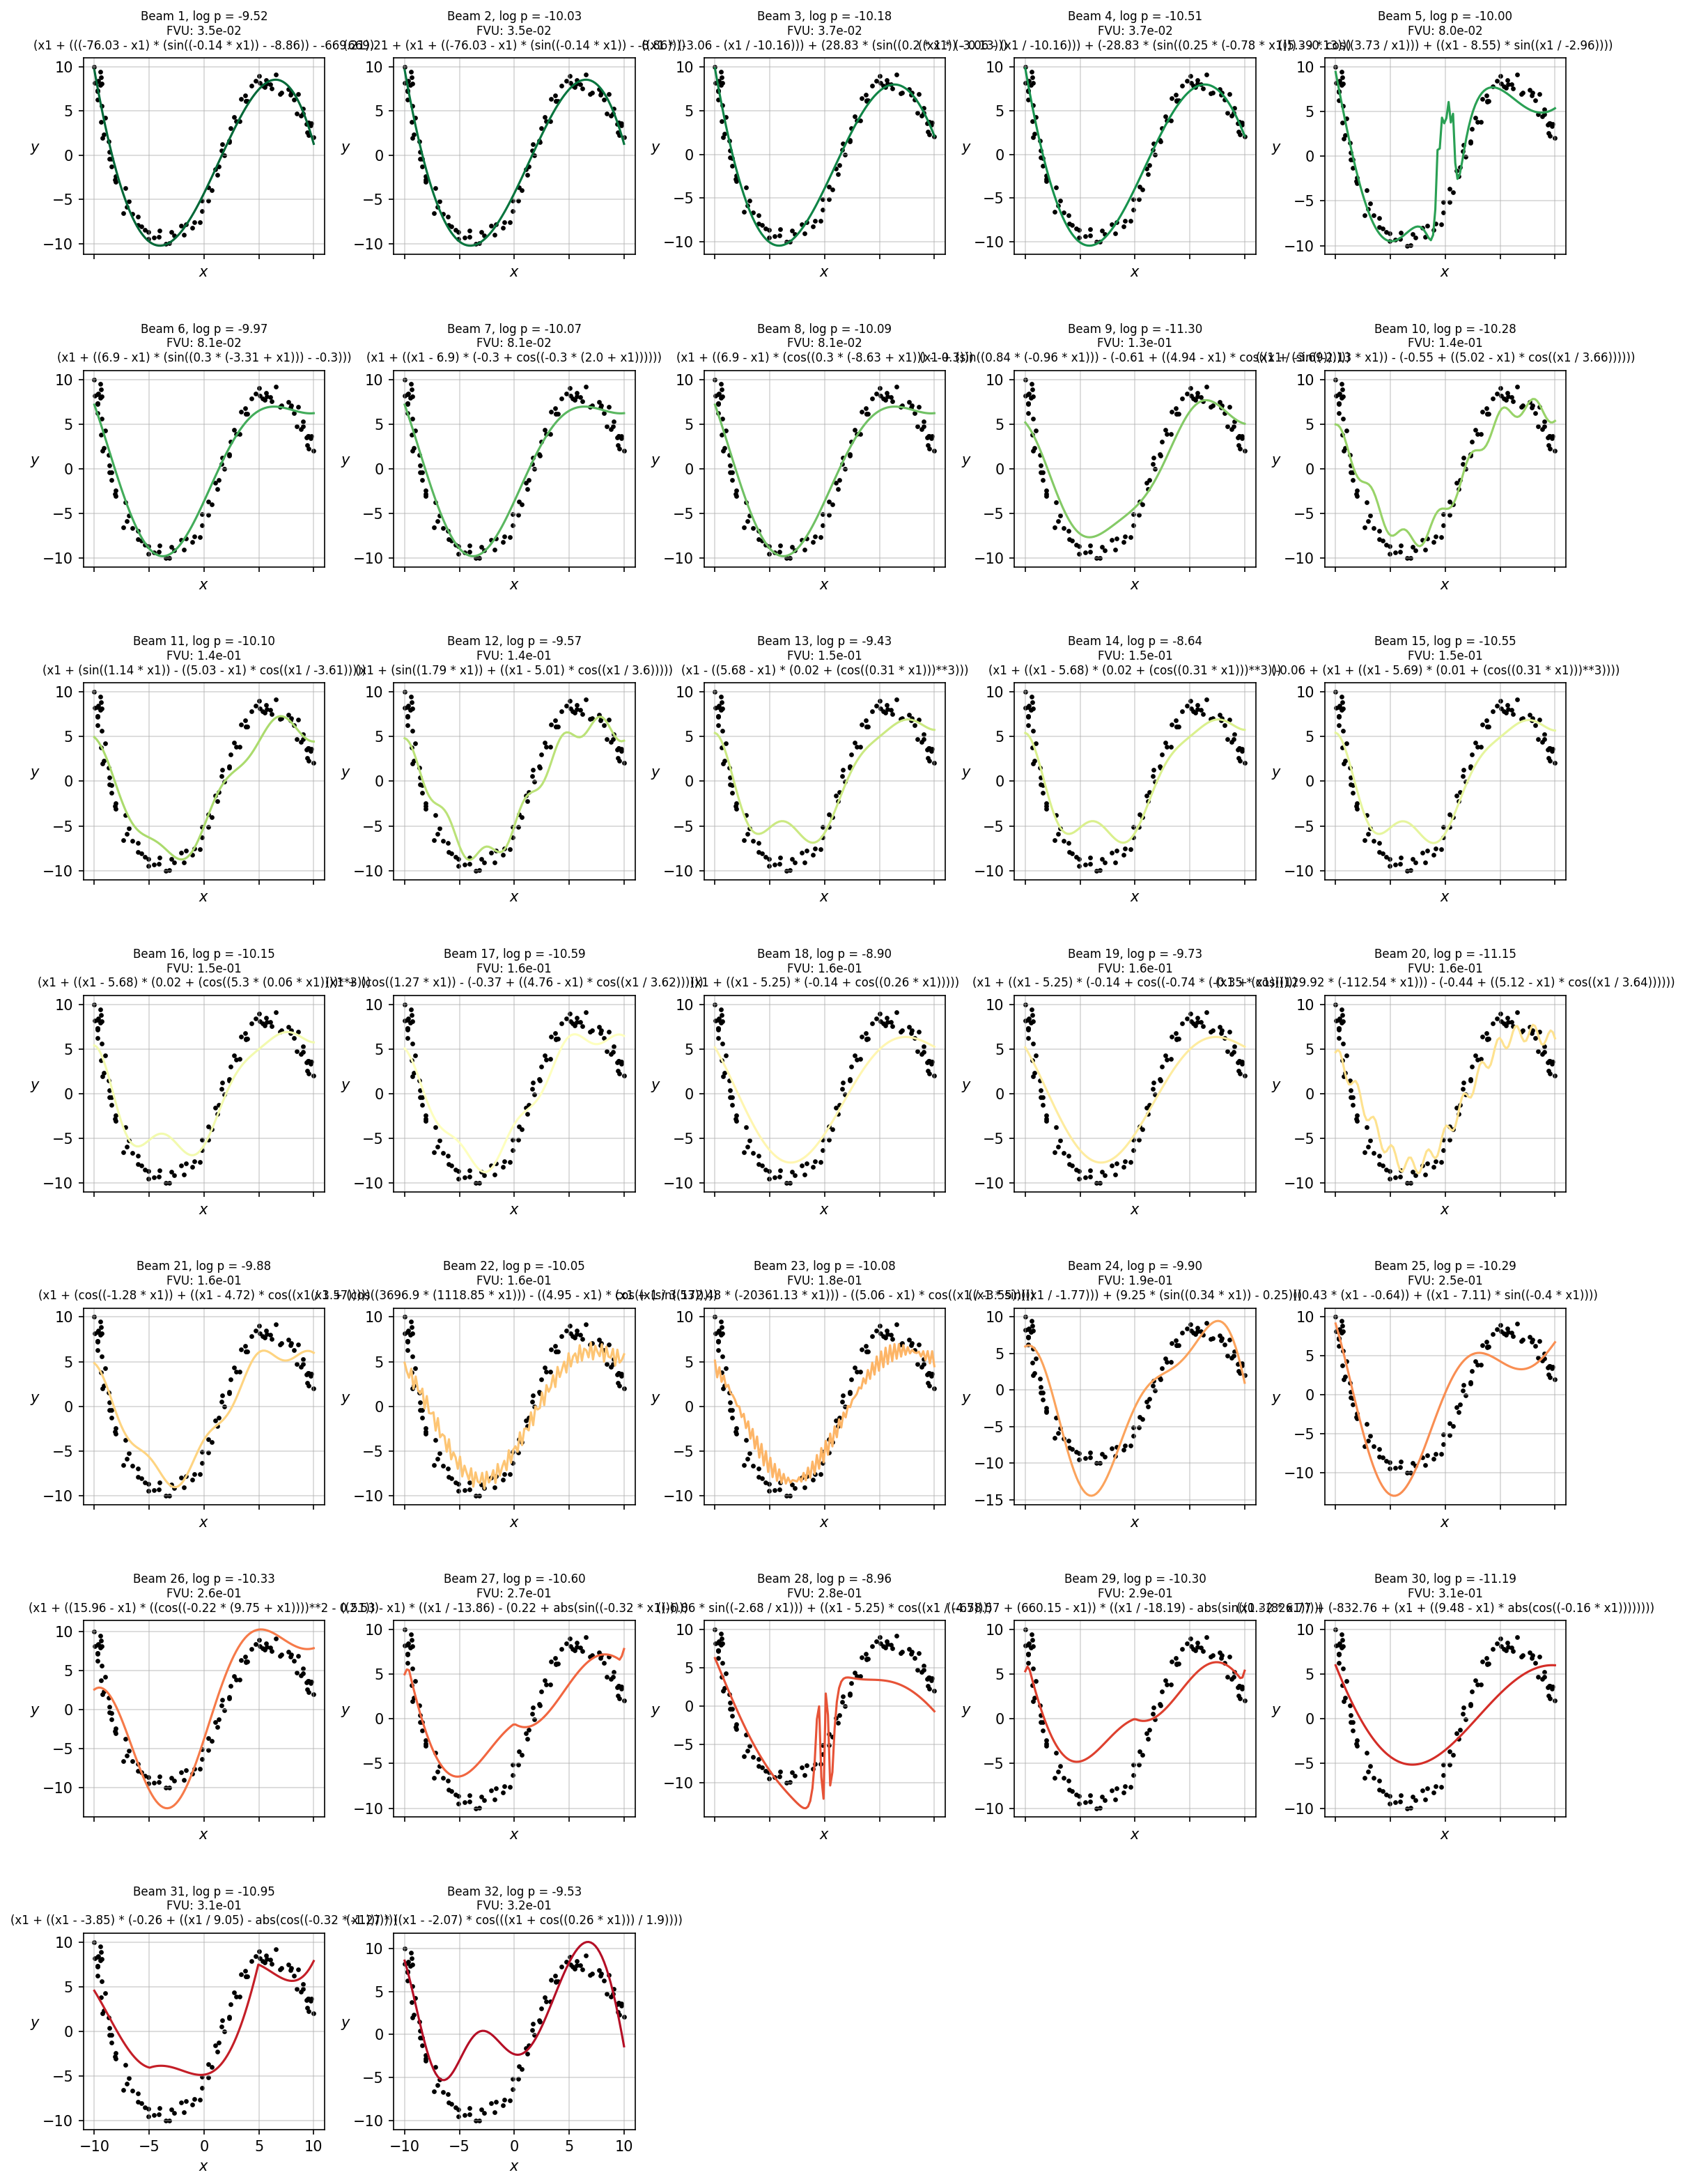

In [31]:
COLS = 5
ROWS = np.ceil(len(y_pred) / COLS).astype(int)

fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 3), dpi=150, sharex=True)

for i, ax in enumerate(axs.flat):
    if i >= len(y_pred) or len(y_pred[i]) == 0:
        ax.axis('off')
        continue
    fvu = np.mean((y_pred[i][0][:, 0] - y)**2) / np.var(y)
    expression_pred_transformed = nsr._results[i][0].transform(nsr._results[i][1]['expression'], 0, return_prefix=True)
    expression_pred_transformed_infix = nsr.expression_space.prefix_to_infix(expression_pred_transformed, power='**')

    ax.plot(X_linspace, y_pred_linspace[i][0], color=plt.get_cmap('RdYlGn')(1 - i / len(y_pred)))
    ax.scatter(X, y, color='k', s=5)
    ax.set_title(f'Beam {i + 1}, log p = {nsr._results[i][1]["log_prob"]:.2f}\nFVU: {fvu:.1e}\n{expression_pred_transformed_infix}', fontsize=8)
    ax.grid(alpha=0.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$', rotation=0, labelpad=5)

fig.tight_layout(h_pad=3)